In [1]:
import sys
sys.path.append("..")

import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

from julia import Main
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 5
nexcite = 3
ntotal = 8

In [3]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix53toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix53toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix53toy3.csv',delimiter=',')

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

In [5]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,
                 Ee,Ee,Ee])

In [6]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

In [8]:
ham.transformed

Matrix([
[             -2*B*g - 1.0*Δ,                           0,                            0,                          0,                          0, -0.204124145231932*Ω*sin(θ),                           0,                            0],
[                          0,                -B*g - 1.0*Δ,                            0,                          0,                          0,  0.204124145231932*Ω*cos(θ), -0.144337567297406*Ω*sin(θ),                            0],
[                          0,                           0,                       -1.0*Δ,                          0,                          0, 0.0833333333333334*Ω*sin(θ),  0.235702260395516*Ω*cos(θ), -0.0833333333333334*Ω*sin(θ)],
[                          0,                           0,                            0,                B*g - 1.0*Δ,                          0,                           0,  0.144337567297406*Ω*sin(θ),   0.204124145231932*Ω*cos(θ)],
[                          0,                          

In [9]:
ham.hamiltonian

Matrix([
[                                -2*B*g + E0,                                           0,                                            0,                                          0,                                          0, -0.204124145231932*Ω*exp(1.0*I*t*ω)*sin(θ),                                          0,                                           0],
[                                          0,                                   -B*g + E0,                                            0,                                          0,                                          0,  0.204124145231932*Ω*exp(1.0*I*t*ω)*cos(θ), -0.144337567297406*Ω*exp(1.0*I*t*ω)*sin(θ),                                           0],
[                                          0,                                           0,                                           E0,                                          0,                                          0, 0.0833333333333334*Ω*exp(1.0*I*t*ω)*sin(θ),  0.2

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [12]:
BR[nground:,:]

array([[0.6, 0.3, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.3, 0.4, 0.3, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.3, 0.6, 0. , 0. , 0. ]])

In [13]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


In [14]:
dis.dissipator

Matrix([
[            0.6*Γ*ρ₅₅(t),                        0,                                        0,                        0,                        0,            -0.5*Γ*ρ₀₅(t),            -0.5*Γ*ρ₀₆(t), -0.5*Γ*ρ₀₇(t)],
[                       0,  0.3*Γ*(ρ₅₅(t) + ρ₆₆(t)),                                        0,                        0,                        0,            -0.5*Γ*ρ₁₅(t),            -0.5*Γ*ρ₁₆(t), -0.5*Γ*ρ₁₇(t)],
[                       0,                        0, Γ*(0.1*ρ₅₅(t) + 0.4*ρ₆₆(t) + 0.1*ρ₇₇(t)),                        0,                        0,            -0.5*Γ*ρ₂₅(t),            -0.5*Γ*ρ₂₆(t), -0.5*Γ*ρ₂₇(t)],
[                       0,                        0,                                        0,  0.3*Γ*(ρ₆₆(t) + ρ₇₇(t)),                        0,            -0.5*Γ*ρ₃₅(t),            -0.5*Γ*ρ₃₆(t), -0.5*Γ*ρ₃₇(t)],
[                       0,                        0,                                        0,                        0,           

In [15]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 488 ms


In [16]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

In [17]:
nprocs = 12 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [18]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [19]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [20]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(ntotal):
    y0[_,_] = 1/ntotal
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [21]:
print(hamiltonian_symbols,dissipator_symbols)

{Ω, θ, g, Δ, B} {Γ}


In [22]:
Main.eval("""
    @everywhere begin
    Γ_val = 1
    Δgroup = 0E-3
    Ω_val = 3*Γ_val
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [23]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    θ => 30*pi/180,
    B => 3,
    Δ => Δgroup,
    Ω => Ω_val,
    g => 1,
    Γ => Γ_val,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [26]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 3000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

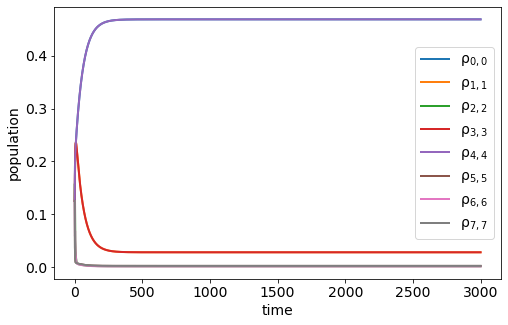

In [27]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

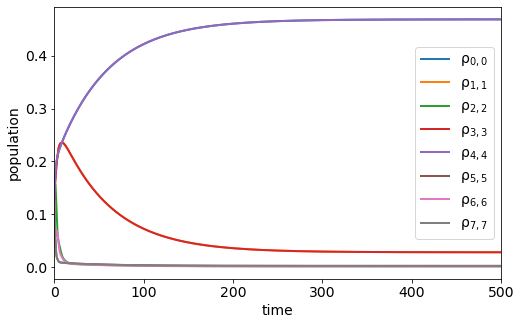

In [68]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.set_xlim([0, 500])
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

# Sweep B field and theta Omega = Gamma

In [39]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,40)
var2list = np.linspace(-1,1,40)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [40]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    Ω_val = Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ => Δgroup,
        Ω => Ω_val,
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [41]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [42]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

45.335225

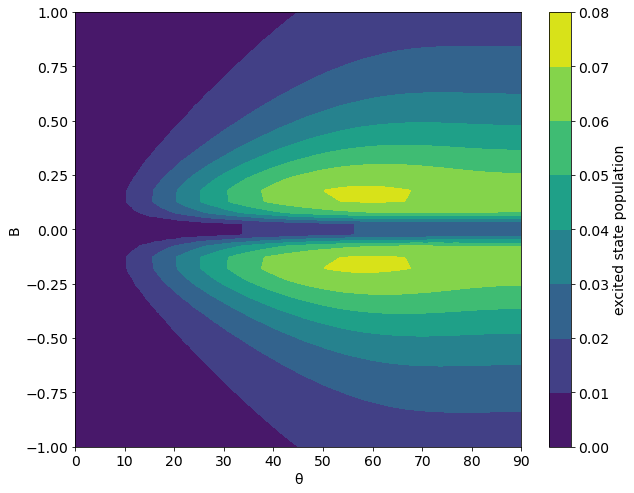

In [43]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and theta Omega = 0.1 Gamma longer evolution time

In [86]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,40)
var2list = np.linspace(0,1,20)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [87]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    Ω_val = 0.1*Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ => Δgroup,
        Ω => Ω_val,
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
    tspannew = (0.0, 300000.)
    remake(prob, p = pnew, tspan = tspannew)
end
""")

In [88]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [ ]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/300000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and theta Omega = 0.1 Gamma

In [74]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,40)
var2list = np.linspace(0,1,20)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [1]:
-0.01 * 0.925 + 0.001

-0.00825

In [75]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    Ω_val = 0.1*Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ => Δgroup,
        Ω => Ω_val,
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [76]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [77]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

27.2627764

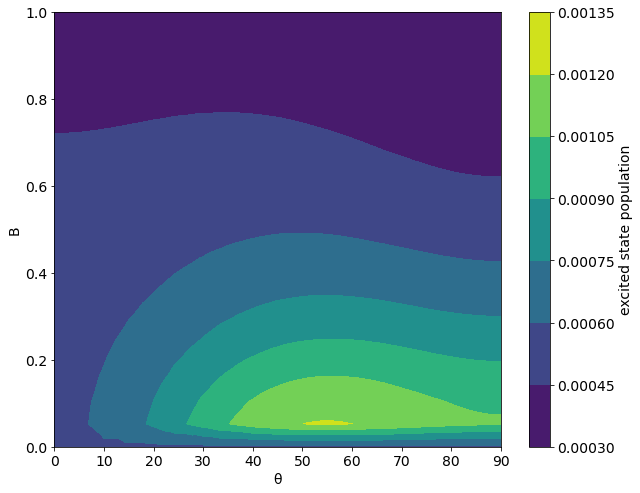

In [78]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and theta Omega = Gamma

In [45]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,40)
var2list = np.linspace(0,1,20)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [46]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    Ω_val = Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ => Δgroup,
        Ω => Ω_val,
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [47]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [48]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

21.7249696

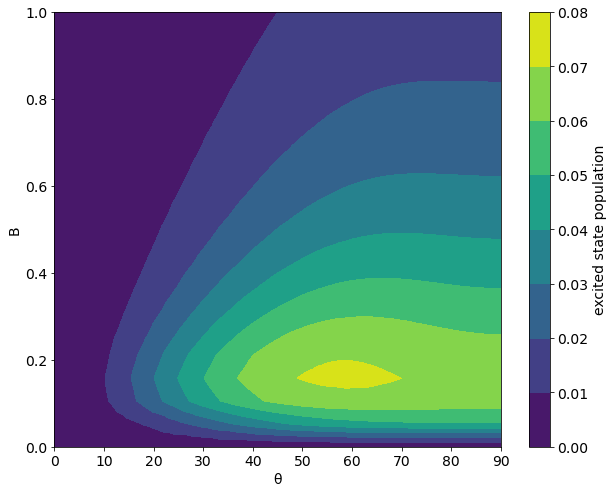

In [49]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and theta at omega=10gamma

In [57]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [58]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

646.2564009

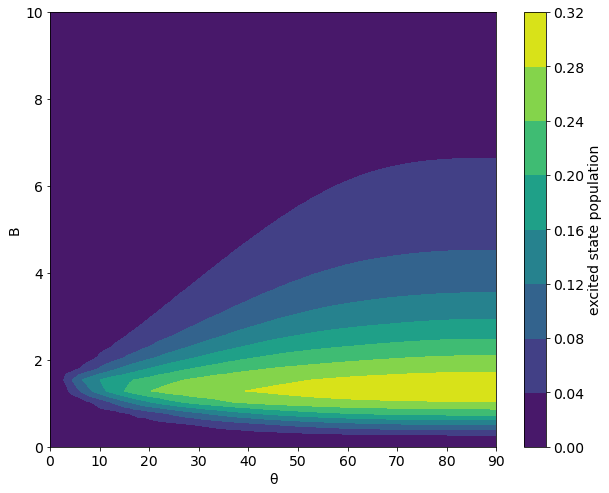

In [59]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and rabi rate

In [79]:
# creating the parameter space to scan
var1list = np.linspace(0,20,30)
var2list = np.linspace(0,5,30)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [80]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    pnew = ModelingToolkit.varmap_to_vars([
        θ => 60/180*pi,
        B => params[i,2],
        Δ => Δgroup,
        Ω => params[i,1],
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [81]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [82]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

156.850944

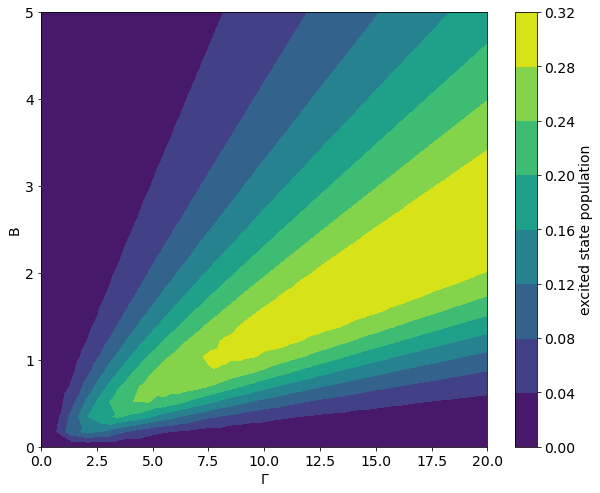

In [84]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Γ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Sweep B field and rabi rate

In [69]:
# creating the parameter space to scan
var1list = np.linspace(0,10,20)
var2list = np.linspace(0,5,20)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [70]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    pnew = ModelingToolkit.varmap_to_vars([
        θ => 90/180*pi,
        B => params[i,2],
        Δ => Δgroup,
        Ω => params[i,1],
        g => 1,
        Γ => Γ_val,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [71]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(6-1)*9])+real(sol.u[j][1+(7-1)*9])+real(sol.u[j][1+(8-1)*9]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [72]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

75.7226873

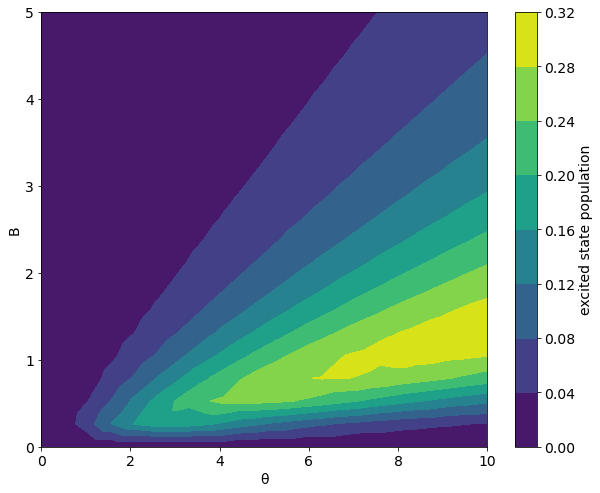

In [73]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u"))/3000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)